# Time Series Cleaning and Exploring Data

### Import Libraries

In [1]:
import pandas as pd
import _pickle as pickle
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### Reading in the Data

In [2]:
with open("stock_df.pkl", "rb") as fp:
    df = pickle.load(fp)

### Setting the index as the Date

In [3]:
# Converting to datetime format
df.Date = pd.to_datetime(df.Date)

df.set_index('Date', inplace=True)
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-09-30,28.889999,29.049999,28.360001,28.990000,28.990000,37295600
2019-10-01,29.049999,29.540001,28.639999,28.760000,28.760000,37081800
2019-10-02,28.500000,28.850000,28.030001,28.309999,28.309999,43640700
2019-10-03,28.280001,28.780001,27.430000,28.680000,28.680000,56325200
2019-10-04,28.830000,29.059999,28.280001,29.010000,29.010000,34446700


In [4]:
# Converting all values to numeric values
df[df.columns] = df[df.columns].apply(pd.to_numeric)
df.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

### Dataframe set as only time index and closing price

In [5]:
df = df[["Close"]]
df.tail()

,Close
Date,
2019-09-30,28.990000
2019-10-01,28.760000
2019-10-02,28.309999
2019-10-03,28.680000
2019-10-04,29.010000


### Resampling the Data
- Weekly
- Montly

In [6]:
def resampling(df):
    """
    Resamples the daily data for more EDA
    """
    # Resampling the DF, weekly close is set as the last day of the business week
    weekly = df.resample('1W-FRI', closed='right', label='right').last().dropna()
    
    # Resampling DF to the last business day of the month
    monthly = df.resample('BM', closed='right', label='right').last().dropna()
    
    return weekly, monthly

In [7]:
weekly, monthly = resampling(df)

## Plotting the Historical Prices for the stock

### Plot of the Daily Prices

/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


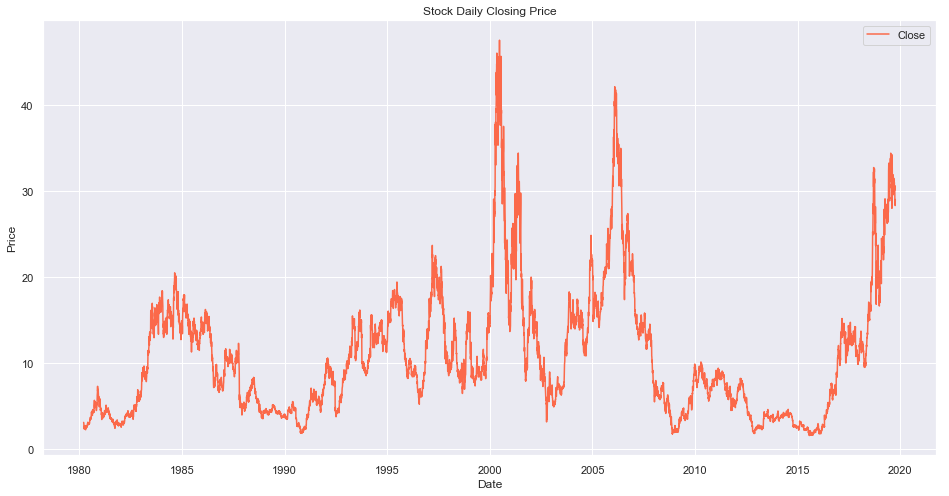

In [8]:
plt.figure(figsize=(16,8))
sns.set_style('darkgrid')

sns.lineplot(data=df, palette='Reds')
plt.title("Stock Daily Closing Price")
plt.ylabel('Price')
plt.show()

### Plots of the Weekly and Monthly Data

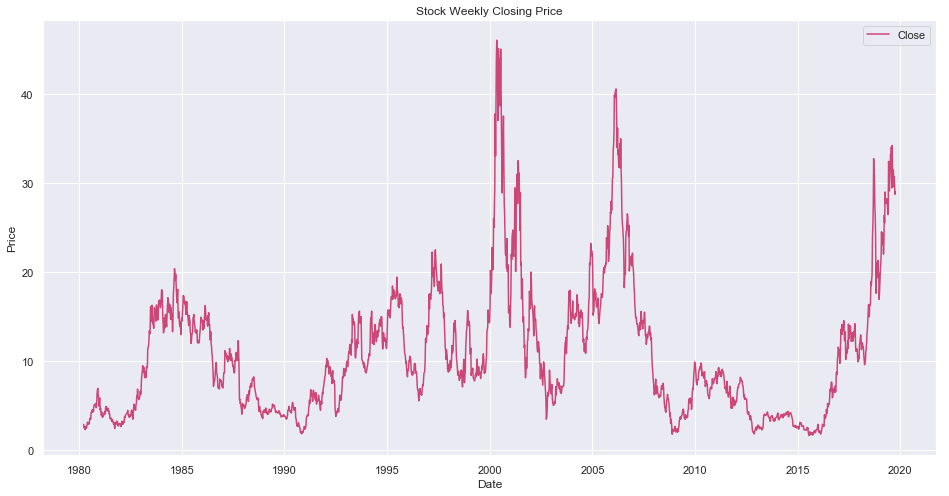

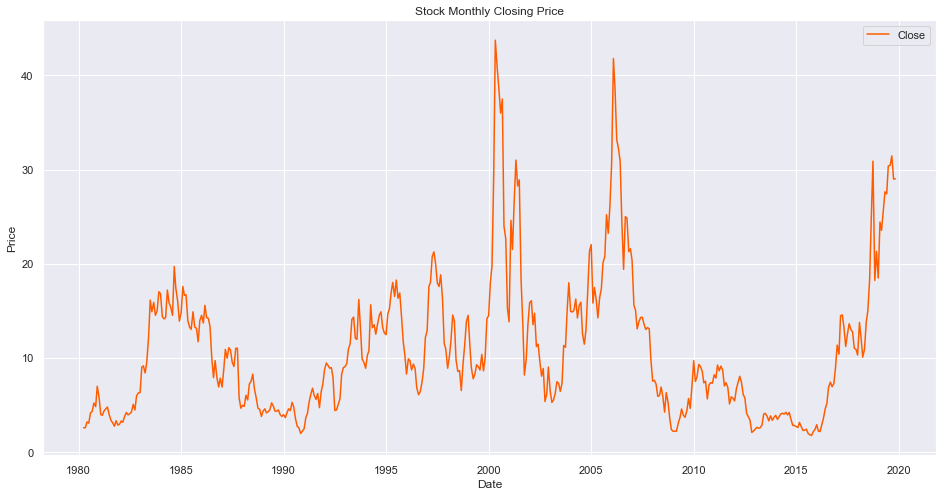

In [9]:
plt.figure(figsize=(16,8))
sns.set_style('darkgrid')

sns.lineplot(data=weekly, palette='plasma')
plt.title("Stock Weekly Closing Price")
plt.ylabel('Price')

plt.figure(figsize=(16,8))
sns.lineplot(data=monthly, palette='hot')
plt.title("Stock Monthly Closing Price")
plt.ylabel('Price')

plt.show()

### Boxplots

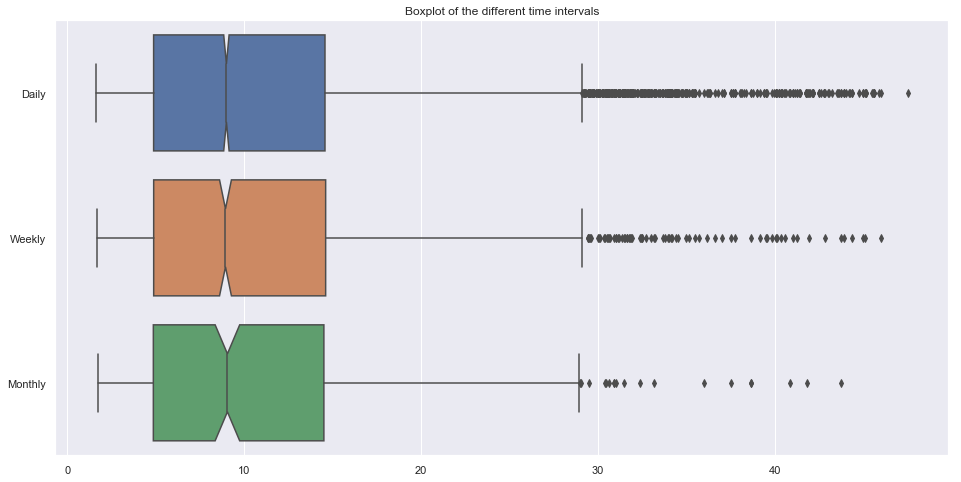

In [10]:
plt.figure(figsize=(16,8))
sns.set_style('darkgrid')

sns.boxplot(data=[df, weekly, monthly], 
            notch=True, orient='h').set(yticklabels=['Daily', 'Weekly', 'Monthly'])
plt.title("Boxplot of the different time intervals")
plt.show()

### Grabbing the closing prices from the last 1000 periods if possible
The last 1000 periods are used for daily and weekly because they better represent the stock's behavior in the current market.

In [11]:
try:
    df = df[-1000:]
    weekly = weekly[-1000:]
except:
    # If the stock has less than 1000 days worth of daily data
    df = df
    weekly = weekly

## Exporting the new DFs

In [12]:
# Daily export
with open("daily_df.pkl", "wb") as fp:
    pickle.dump(df, fp)
    
# Weekly export
with open("week_df.pkl", "wb") as fp:
    pickle.dump(weekly, fp)
    
# Monthly export
with open("month_df.pkl", "wb") as fp:
    pickle.dump(monthly, fp)

### Plotting the Historical Closing Prices of the last 1000 periods for Daily and Weekly

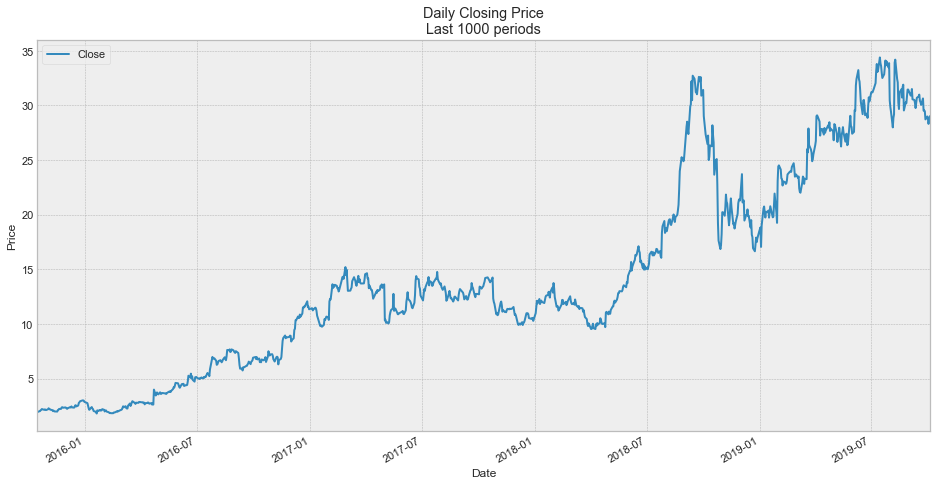

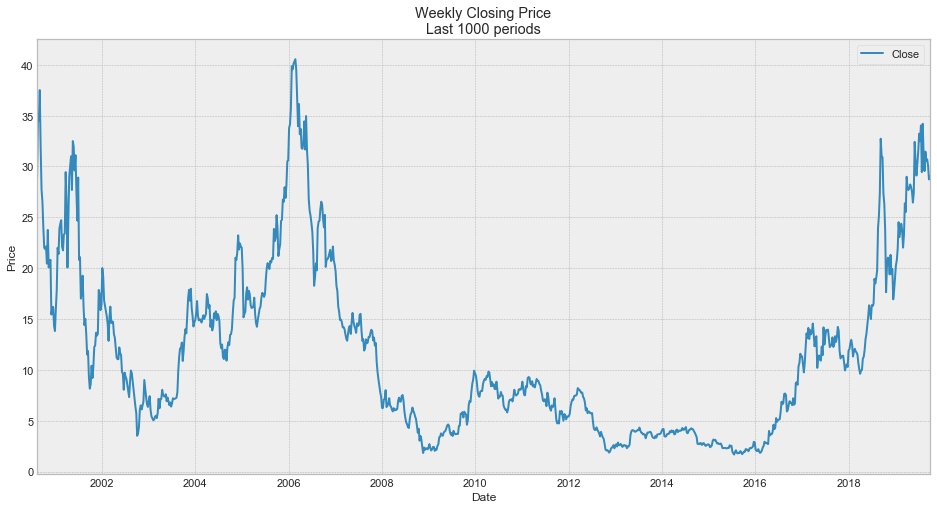

In [13]:
plt.style.use('bmh')
# Daily plot
df.plot(figsize=(16,8))
plt.title("Daily Closing Price\nLast 1000 periods")
plt.ylabel('Price')

# Weekly plot
weekly.plot(figsize=(16,8))
plt.title("Weekly Closing Price\nLast 1000 periods")
plt.ylabel('Price')

plt.show()

### Stationarity Testing

In [14]:
res = adfuller(df.Close)
print(f"P-value: {res[1]}")

P-value: 0.703573062437907


### Detrending by Differencing

Attempting to achieve a lower p-value

In [15]:
res = adfuller(df.Close.diff(1).dropna())
print(f"P-value: {res[1]}")

P-value: 4.9472432176512647e-08


### Plotting the Differences

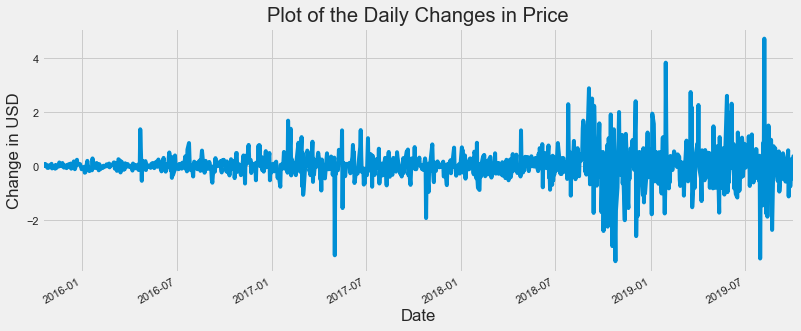

In [16]:
plt.style.use('fivethirtyeight')
# Getting the daily difference
df_diff = df.Close.diff(1).dropna()

# Plotting
df_diff.plot(figsize=(12,5))
plt.title("Plot of the Daily Changes in Price")
plt.ylabel("Change in USD")
plt.show()

## ACF and PACF - Daily
ACF and PACF for the Differenced Data

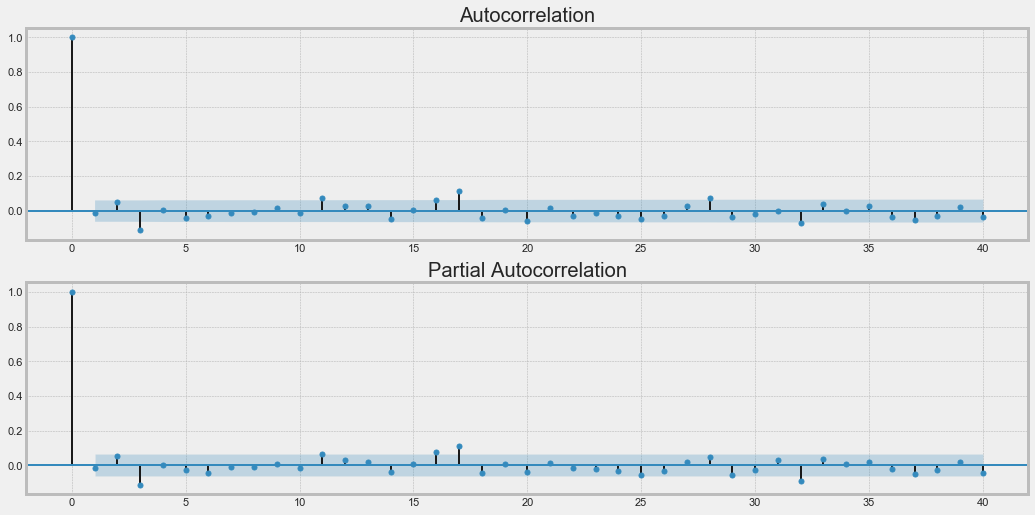

In [17]:
# Plotting the ACF and PACF
plt.style.use('bmh')

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8))
plot_acf(df_diff, ax=ax1, lags=40)
plot_pacf(df_diff, ax=ax2, lags=40)
plt.show()

For comparison, the ACF and PACF for the non-differenced data.

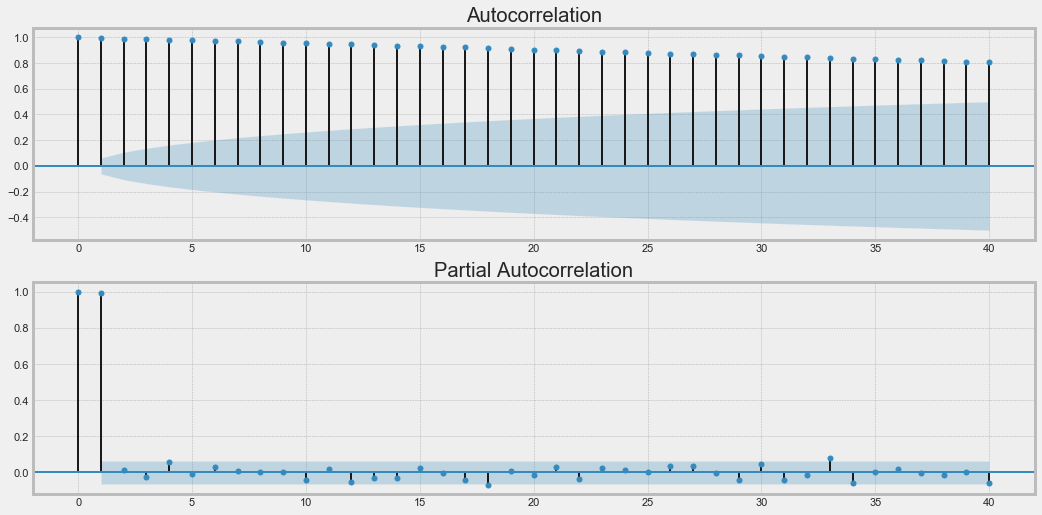

In [18]:
plt.style.use('bmh')
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8))
plot_acf(df, ax=ax1, lags=40)
plot_pacf(df, ax=ax2, lags=40)
plt.show()

## ACF and PACF for the other Time Intervals
#### P-values for each time interval

In [19]:
# P-values for weekly, monthly, and quarterly difference
# Weekly
w_ad = adfuller(weekly.diff(1).dropna().Close)
print(f"Weekly Difference \nP-value: {w_ad[1]}\n")

# Monthly
m_ad = adfuller(monthly.diff(1).dropna().Close)
print(f"Monthly Difference \nP-value: {m_ad[1]}\n")

Weekly Difference 
P-value: 2.3702383688328197e-12

Monthly Difference 
P-value: 6.15530956671763e-21



### Plotting ACF and PACF for other Time Intervals
#### Weekly:

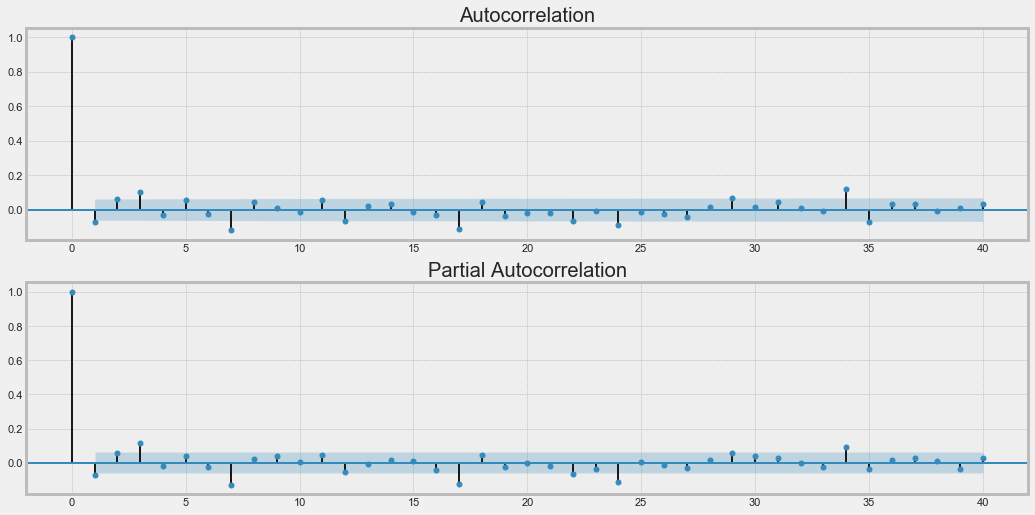

In [20]:
# Plotting the ACF and PACF
plt.style.use('bmh')

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8))
plot_acf(weekly.diff(1).dropna().Close, ax=ax1, lags=40)
plot_pacf(weekly.diff(1).dropna().Close, ax=ax2, lags=40)
plt.show()

#### Monthly:

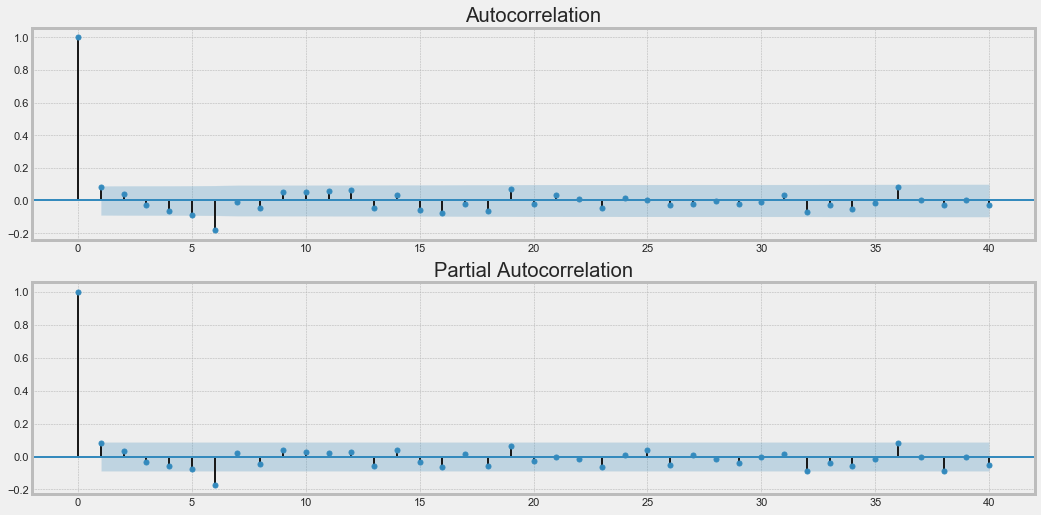

In [21]:
# Plotting the ACF and PACF
plt.style.use('bmh')

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8))
plot_acf(monthly.diff(1).dropna().Close, ax=ax1, lags=40)
plot_pacf(monthly.diff(1).dropna().Close, ax=ax2, lags=40)
plt.show()